# Alpaca Hum Segmentation – Per-tape Insights

**Notebook goal** – Load `metrics_per_tape.csv` produced by `evaluate_benchmark.py` and explore model performance variability *across individual tapes*:

* Distribution of F1 / precision / recall per model
* Heat-map of F1 (<code>tape × variant</code>)
* Precision–Recall scatter (one marker = one <code>model, variant, tape</code>)
* Boundary-error (Δstart/Δend) distributions per model
* Identify the hardest and easiest tapes

In [1]:
import re
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_context("talk")

In [2]:
# ⇩ adjust to wherever you saved the file produced by evaluate_benchmark.py
METRICS_CSV = Path("/Users/danie/repos/alpaca-segmentation/BENCHMARK_TRAINING_CORPUS/metrics_per_tape.csv")
assert METRICS_CSV.exists(), f"{METRICS_CSV} not found"

In [3]:
df = pd.read_csv(METRICS_CSV)

def parse_variant_tag(tag: str):
    """Return seq_len (s), hop (s), threshold (float) from a variant tag."""
    m = re.match(r"len(\d+)_hop(\d+)_th(\d+)", tag)
    if not m:
        return None, None, None
    seq = int(m[1]) / 1000  # back to seconds
    hop = int(m[2]) / 1000
    th  = int(m[3]) / 100
    return seq, hop, th

df[["seq_len_s", "hop_s", "threshold"]] = (
    df["variant"].apply(lambda t: pd.Series(parse_variant_tag(t)))
)

display(df.head())

,n_gt,n_pred,tp,fp,fn,precision,recall,f1,mean_dstart_ms,mean_dend_ms,...,recall_q2,f1_q2,recall_q3,f1_q3,tape,model,variant,seq_len_s,hop_s,threshold
0,55,219,0,219,55,0.000000,0.000000,0.00000,NaN,NaN,...,0.000000,NaN,0.0,NaN,387_20201207_cut.wav,v3_tape_proportional,len500_hop050_th70,0.5,0.05,0.7
1,149,894,4,890,145,0.004474,0.026846,0.00767,193.5,143.5,...,0.055556,0.1,0.0,NaN,387_20201208_cut.wav,v3_tape_proportional,len500_hop050_th70,0.5,0.05,0.7
2,75,0,0,0,75,0.000000,0.000000,0.00000,NaN,NaN,...,0.000000,NaN,0.0,NaN,387_20201214_cut.wav,v3_tape_proportional,len500_hop050_th70,0.5,0.05,0.7
3,23,0,0,0,23,0.000000,0.000000,0.00000,NaN,NaN,...,0.000000,NaN,0.0,NaN,387_20201215_cut.wav,v3_tape_proportional,len500_hop050_th70,0.5,0.05,0.7
4,8,0,0,0,8,0.000000,0.000000,0.00000,NaN,NaN,...,0.000000,NaN,0.0,NaN,388_20201207_1and2_cut.wav,v3_tape_proportional,len500_hop050_th70,0.5,0.05,0.7


## 1 · Performance spread per model

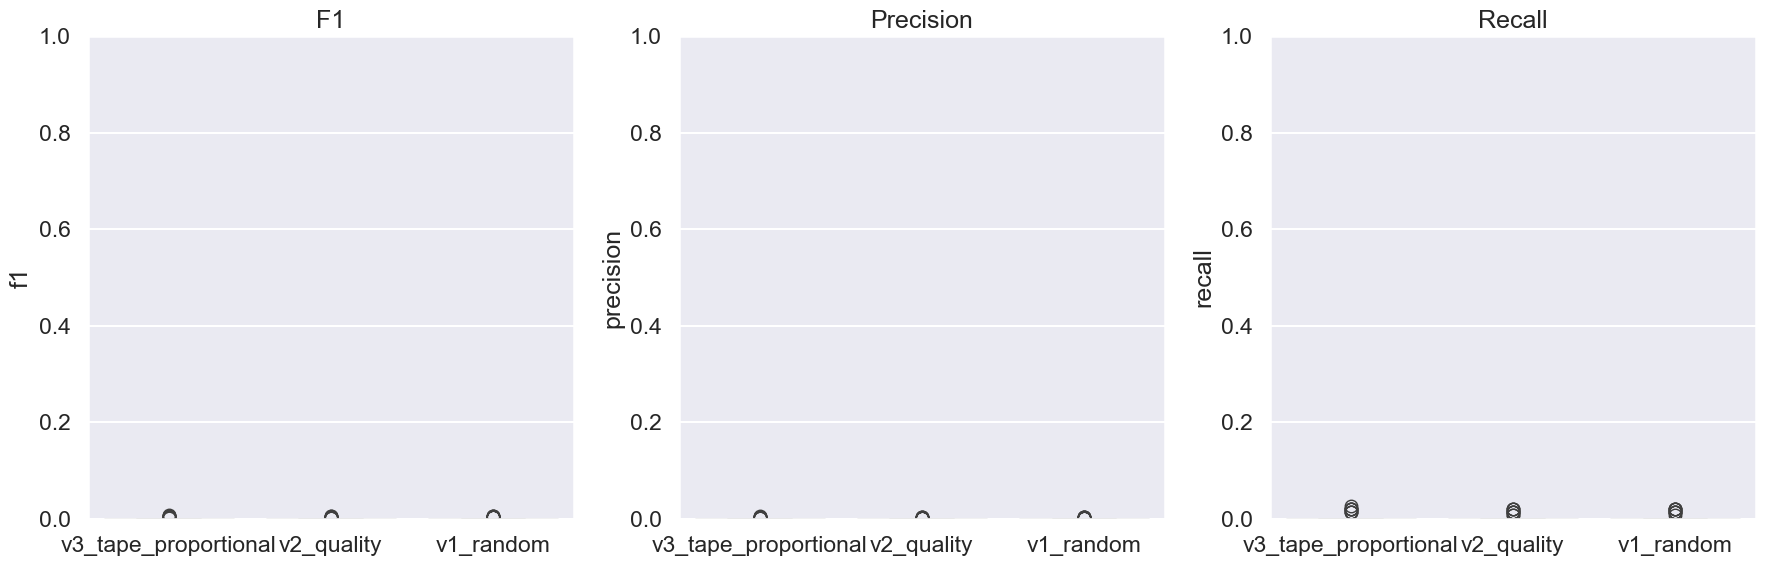

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for ax, metric, title in zip(
    axs,
    ["f1", "precision", "recall"],
    ["F1", "Precision", "Recall"],
):
    sns.boxplot(x="model", y=metric, data=df, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("")
    ax.set_ylabel(metric)
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

## 2 · F1 heat-map (tape × variant)

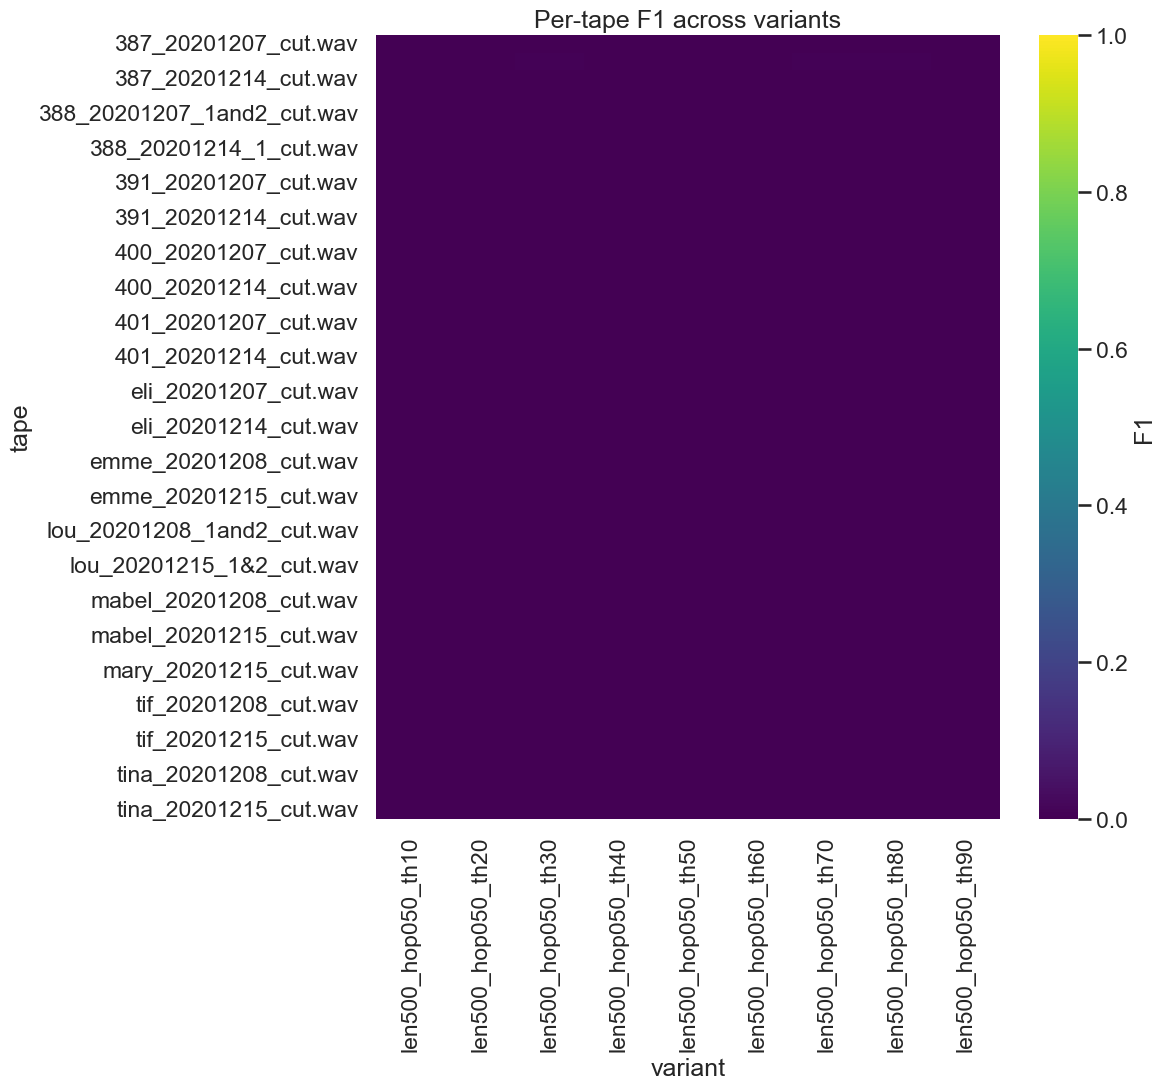

In [5]:
# This can get wide – filter or pivot as needed
pivot = df.pivot_table(index="tape", columns="variant", values="f1")

plt.figure(figsize=(max(12, 0.4 * len(pivot.columns)), max(10, 0.25 * len(pivot))))
sns.heatmap(
    pivot,
    annot=False,
    cmap="viridis",
    vmin=0,
    vmax=1,
    cbar_kws={"label": "F1"},
)
plt.title("Per-tape F1 across variants")
plt.xlabel("variant")
plt.ylabel("tape")
plt.tight_layout()
plt.show()

## 3 · Recall heat-map (tape × variant)

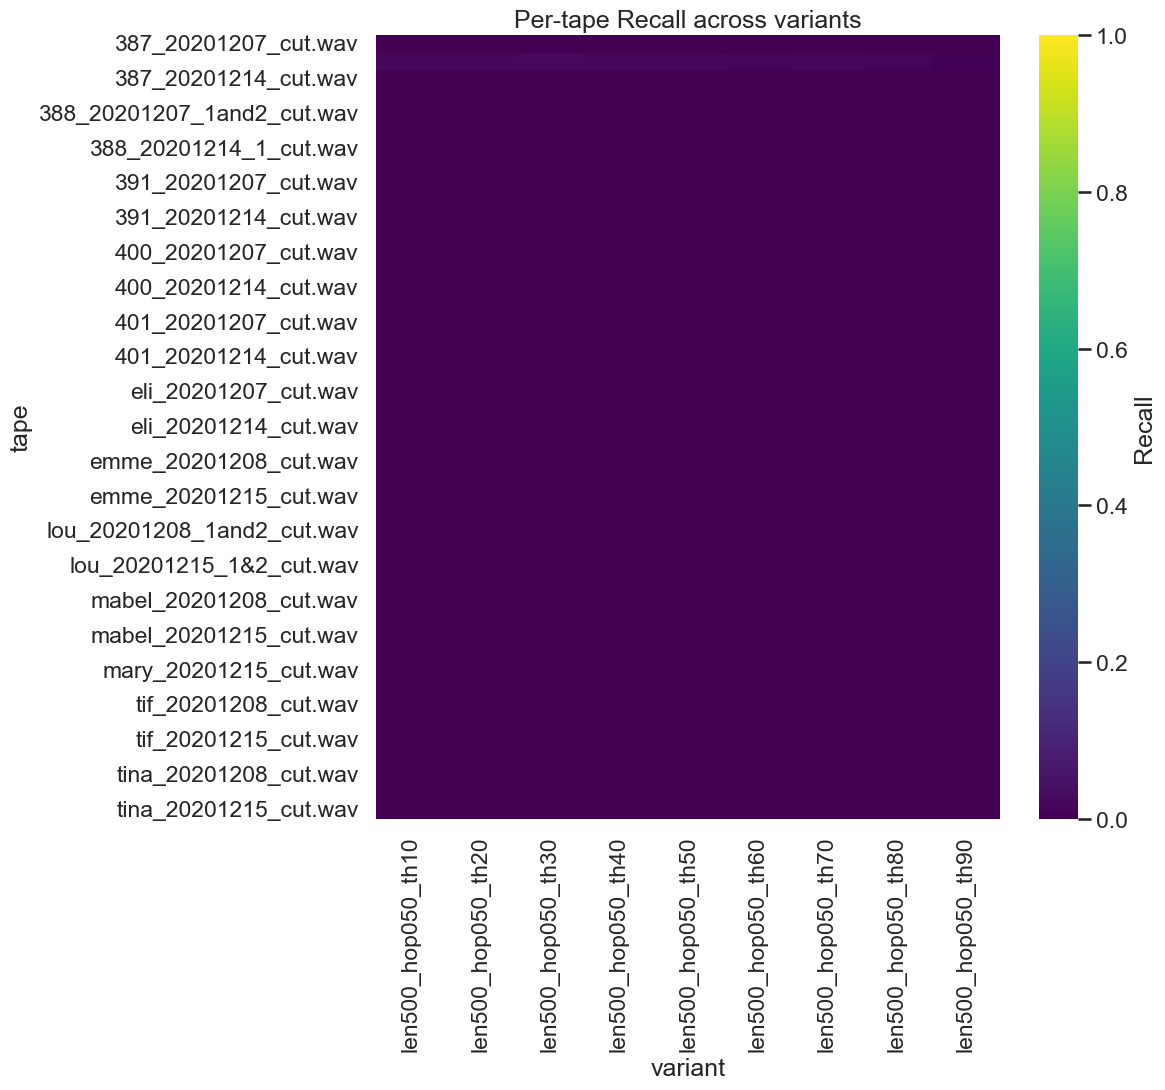

In [6]:
# This can get wide – filter or pivot as needed
pivot = df.pivot_table(index="tape", columns="variant", values="recall")

plt.figure(figsize=(max(12, 0.4 * len(pivot.columns)), max(10, 0.25 * len(pivot))))
sns.heatmap(
    pivot,
    annot=False,
    cmap="viridis",
    vmin=0,
    vmax=1,
    cbar_kws={"label": "Recall"},
)
plt.title("Per-tape Recall across variants")
plt.xlabel("variant")
plt.ylabel("tape")
plt.tight_layout()
plt.show()

## 4 · Precision heat-map (tape × variant)

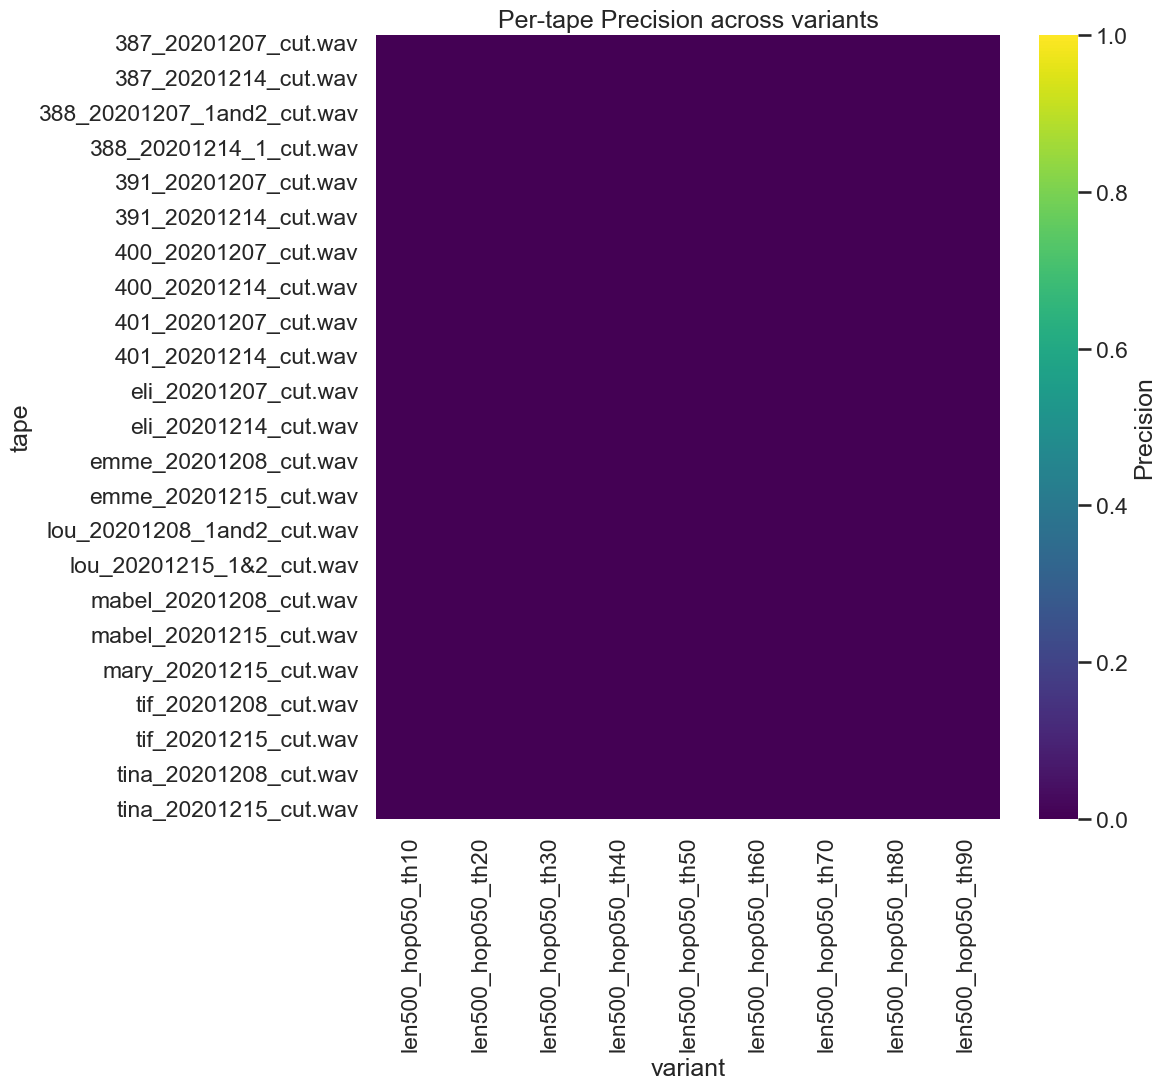

In [7]:
# This can get wide – filter or pivot as needed
pivot = df.pivot_table(index="tape", columns="variant", values="precision")

plt.figure(figsize=(max(12, 0.4 * len(pivot.columns)), max(10, 0.25 * len(pivot))))
sns.heatmap(
    pivot,
    annot=False,
    cmap="viridis",
    vmin=0,
    vmax=1,
    cbar_kws={"label": "Precision"},
)
plt.title("Per-tape Precision across variants")
plt.xlabel("variant")
plt.ylabel("tape")
plt.tight_layout()
plt.show()

## 5 · Hardest & easiest tapes

In [8]:
# Mean F1 over variants for each tape – lower = harder
tape_mean = df.groupby("tape")["f1"].mean()

hardest = tape_mean.nsmallest(10)
easiest = tape_mean.nlargest(10)

print("### Hardest tapes (mean F1)\n", hardest)
print("\n### Easiest tapes (mean F1)\n", easiest)

### Hardest tapes (mean F1)
 tape
387_20201207_cut.wav          0.0
387_20201214_cut.wav          0.0
387_20201215_cut.wav          0.0
388_20201207_1and2_cut.wav    0.0
388_20201208_1and2_cut.wav    0.0
388_20201214_1_cut.wav        0.0
388_20201215_1&2_cut.wav      0.0
391_20201207_cut.wav          0.0
391_20201208_cut.wav          0.0
391_20201214_cut.wav          0.0
Name: f1, dtype: float64

### Easiest tapes (mean F1)
 tape
387_20201208_cut.wav          0.003711
387_20201207_cut.wav          0.000000
387_20201214_cut.wav          0.000000
387_20201215_cut.wav          0.000000
388_20201207_1and2_cut.wav    0.000000
388_20201208_1and2_cut.wav    0.000000
388_20201214_1_cut.wav        0.000000
388_20201215_1&2_cut.wav      0.000000
391_20201207_cut.wav          0.000000
391_20201208_cut.wav          0.000000
Name: f1, dtype: float64
